In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from preprocess import process_cad_rads_labels, evaluate_performance, plot_confusion_matrix, compare_certainty, make_many_shot_prompt

In [2]:
API = 'chatgpt'
# API = 'claude'
# API = 'gemini'
API = 'deepseek'

In [3]:
USE_COT = True
# USE_COT = False

# USE_CERTAINTY = True
USE_CERTAINTY = False

# USE_MANYSHOT = True
USE_MANYSHOT = False

MAX_OUTPUT_LENGTH = 1000 if USE_COT else 50

In [4]:

if API == 'chatgpt':
    from openai import OpenAI
    api_key = 'YOUR_API_KEY'
    client = OpenAI(api_key=api_key)

elif API == "claude":
    import anthropic
    api_key = 'YOUR_API_KEY'
    client = anthropic.Anthropic(api_key=api_key)

elif API == "gemini":
    import google.generativeai as genai
    api_key = 'YOUR_API_KEY'
    genai.configure(api_key=api_key)
elif API == "deepseek":
    import openai
    client = openai.Client(base_url="http://147.46.97.232:3032/v1", api_key="None")

print(API)

chatgpt


In [5]:
# VERSION = 'v3.1'
# VERSION = 'v4.0'
# VERSION = 'v5.1'
# VERSION = 'v6.0'
# VERSION = 'v6.1'
# VERSION = 'v6.2'
# VERSION = 'v6.3'
VERSION = 'v6.4'

# data = pd.read_csv('sample_processed.csv')
# data = pd.read_csv('sample_processed_v2.2.csv')
# data = pd.read_csv('sample_processed_v2.3.csv')
# data = pd.read_csv('sample_processed_v3.0.csv')
# data = pd.read_csv(f'sample_processed_{VERSION}.csv')
data = pd.read_csv(f'sample_processed_{VERSION}(외부병원).csv')


data.fillna(value='None', inplace=True)

In [6]:
institution = pd.read_csv('external_w_institution.csv')['Institution']
data['Institution'] = institution

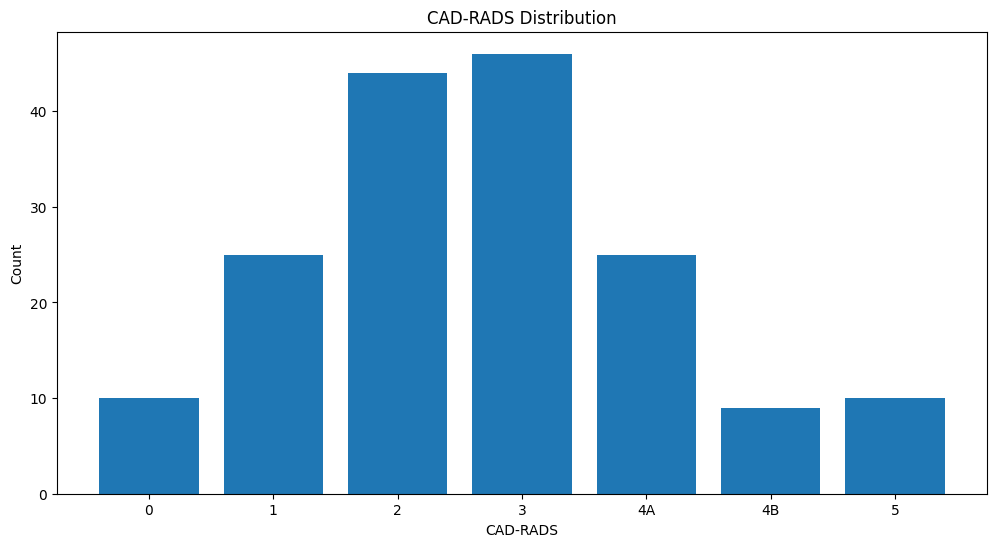

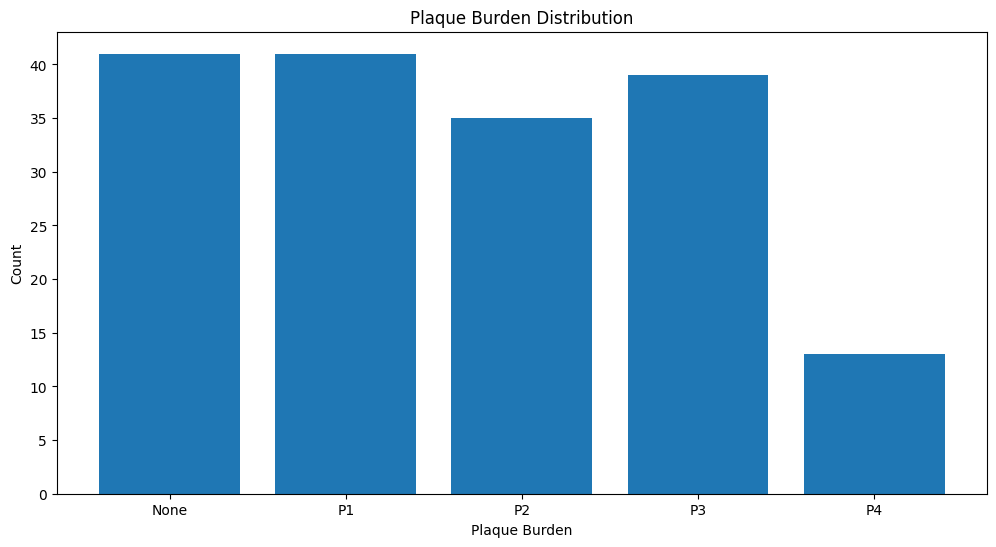

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# CAD-RADS 분포 그래프
plt.figure(figsize=(12, 6))
cad_rads_order = ['0', '1', '2', '3', '4A', '4B', '5']
cad_rads_counts = data['CAD-RADS'].value_counts().reindex(cad_rads_order).fillna(0)

plt.bar(cad_rads_counts.index, cad_rads_counts.values)
plt.title('CAD-RADS Distribution')
plt.xlabel('CAD-RADS')
plt.ylabel('Count')
plt.show()

# Plaque burden 분포 그래프
plt.figure(figsize=(12, 6))
plaque_burden_order = ['None', 'P1', 'P2', 'P3', 'P4']
plaque_burden_counts = data['Plaque Burden'].value_counts().reindex(plaque_burden_order).fillna(0)

plt.bar(plaque_burden_counts.index, plaque_burden_counts.values)
plt.title('Plaque Burden Distribution')
plt.xlabel('Plaque Burden')
plt.ylabel('Count')
plt.show()

In [ ]:
cad_rads_order = ['0', '1', '2', '3', '4A', '4B', '5']
plaque_burden_order = ['None', 'P1', 'P2', 'P3', 'P4']

for i in list(set(institution)):
    data_inst = data[data['Institution']==i]

    cad_rads_counts = data_inst['CAD-RADS'].value_counts().reindex(cad_rads_order).fillna(0)
    plaque_burden_counts = data_inst['Plaque Burden'].value_counts().reindex(plaque_burden_order).fillna(0)
    print(f'Institution {i} stenosis',cad_rads_counts)
    print(f'Institution {i} plaque burden ',plaque_burden_counts)

    print(data_inst['E'].value_counts())
    print(data_inst['N'].value_counts())
    print(data_inst['G'].value_counts())
    print(data_inst['HRP'].value_counts())
    print(data_inst['S'].value_counts())
    print(data_inst['I'].value_counts())



Institution E (n=53) stenosis 0      0.0
1      9.0
2     14.0
3     14.0
4A     8.0
4B     4.0
5      4.0
Name: CAD-RADS, dtype: float64
Institution E (n=53) plaque burden  None     8
P1      15
P2      11
P3      16
P4       3
Name: Plaque Burden, dtype: int64
0    52
1     1
Name: E, dtype: int64
0    51
1     2
Name: N, dtype: int64
0    53
Name: G, dtype: int64
0    51
1     2
Name: HRP, dtype: int64
0    48
1     5
Name: S, dtype: int64
0    53
Name: I, dtype: int64
Institution C (n=30) stenosis 0      0.0
1      3.0
2      6.0
3     13.0
4A     8.0
4B     0.0
5      0.0
Name: CAD-RADS, dtype: float64
Institution C (n=30) plaque burden  None     1
P1       8
P2       9
P3      10
P4       2
Name: Plaque Burden, dtype: int64
0    30
Name: E, dtype: int64
0    30
Name: N, dtype: int64
0    30
Name: G, dtype: int64
0    28
1     2
Name: HRP, dtype: int64
0    30
Name: S, dtype: int64
0    30
Name: I, dtype: int64
Institution D (n=27) stenosis 0     2.0
1     7.0
2     5.0
3     5.0


In [9]:
if not USE_COT:
    # f = open("prompt_system.txt", 'r')
    # f = open("prompt_system_0612.txt", 'r')
    # f = open("prompt_system_0705.txt", 'r')
    # f = open("prompt_system_0828.txt", 'r')
    # f = open("prompt_system_0830.txt", 'r')
    f = open("prompt_system_1016.txt", 'r', encoding='utf-8')
elif USE_COT and not USE_CERTAINTY:
    # f = open("prompt_system_0828_cot.txt", 'r')
    # f = open("prompt_system_0829_cot.txt", 'r')
    # f = open("prompt_system_0830_cot.txt", 'r')
    # f = open("prompt_system_0913_cot.txt", 'r', encoding='utf-8')
    # f = open("prompt_system_0930_cot.txt", 'r', encoding='utf-8')
    f = open("prompt_system_1016_cot_edit.txt", 'r', encoding='utf-8')
elif USE_COT and USE_CERTAINTY:
    # f = open("prompt_system_0913_cot_certainty.txt", 'r', encoding='utf-8')
    # f = open("prompt_system_0930_cot_edit_certainty.txt", 'r', encoding='utf-8')
    # f = open("prompt_system_1014_cot_edit_certainty.txt", 'r', encoding='utf-8')
    f = open("prompt_system_1016_cot_edit_certainty.txt", 'r', encoding='utf-8')

prompt_sys = f.read()
f.close()
print(prompt_sys)


You need to extract the CAD-RADS, Plaque burden, and Modifier from a coronary artery CT report. Refer to the information below:

CAD-RADS
CAD-RADS is determined based on the most severe stenosis among various coronary branches:
- 0: 0%, Absence of CAD
- 1: 1-24%, Minimal non-obstructive CAD
- 2: 25-49%, Mild non-obstructive CAD (Mild stenosis)
- 3: 50-69%, Moderate stenosis
- 4A: 70-99% in a single or 2-vessel, Severe stenosis
- 4B: If the left main (LM) shows stenosis of 50% (moderate) or higher, or if 3-vessel(including LAD, LCx, RCA, OM, D, PDA) have stenosis of 70% (severe) or higher.
- 5: 100% Total coronary occlusion
 
Plaque Burden
Plaque Burden is determined by the overall amount of coronary plaque and Coronary artery calcium (CAC):
- None: 0
- P1: Mild, 1-100
- P2: Moderate, 101-300
- P3: Severe, 301-999
- P4: Extensive, >1000

Modifiers 
There are 6 modifiers that can be added to the CAD-RADS category. More than one modifiers can be applicable:
- N: If "Limited evaluation due

In [10]:
if not USE_COT:
    f = open("prompt_user_few.txt", 'r')

elif USE_COT and not USE_CERTAINTY:
    # f = open("prompt_user_few_cot.txt", 'r')
    if USE_MANYSHOT:
        f = open("prompt_user_few_cot_ManyShot.txt", 'r')
    else:
        f = open("prompt_user_few_cot_UpperEnd.txt", 'r')


elif USE_COT and USE_CERTAINTY:
    # f = open("prompt_user_few_cot_certainty.txt", 'r')
    f = open("prompt_user_few_cot_certainty_UpperEnd.txt", 'r')


prompt_user_few = f.read()
print(prompt_user_few)
f.close()

Extract the CAD-RADS, Plaque burden, and Modifier from a given coronary artery CT report like three examples below.
===
Example 1:

### Report:
s/p OPCAB; RSVG to LITA (Y), LITA to LAD, RSVG to OM1/OM2/PDA (seq).

RSVG to LITA (Y) patent.
LITA to LAD patent graft with good distal run-off.
RSVG to OM1 severe graft stenosis with faint distal run-off.
RSVG to OM2 Segmental occlusion - r/o graft regression.
RSVG to PDA (seq) patent graft with good distal run-off.

LM: <5% stenosis with calcified plaques.
pLCx: 50-60% stenosis with mixed plaques.
dLCx, OM1, OM2: multifocal severe stenosis to occlusion.
LV dilatation.
Diffuse atherosclerosis in thoracic aorta and its major branches without significant stenosis.

### Rationale: 
let's think step by step.

1. CAD-RADS:
- The report mentions "dLCx, OM1, OM2: multifocal severe stenosis to occlusion."
- Occlusion means 100% stenosis, which corresponds to CAD-RADS 5.
- Even though there are bypass grafts, some vessels still show occlusion.
- There

In [11]:
if API=='gemini':
    client = genai.GenerativeModel(
        # model_name="gemini-1.5-flash",
        model_name="gemini-1.5-pro",
        generation_config={
            "temperature": 0,
            "max_output_tokens": MAX_OUTPUT_LENGTH,
            "response_mime_type": "text/plain",
            },
        system_instruction=prompt_sys
        )

In [12]:
def get_response(API, client, prompt_sys, prompt): 
  if API == 'chatgpt':
    response = client.chat.completions.create(
      # model="gpt-4o",
      # model="gpt-4-turbo",
      # messages=[
      #   {
      #     "role": "system",
      #     "content": [
      #       {
      #         "type": "text",
      #         "text": prompt_sys,
      #       }
      #     ]
      #   },
      #   {
      #     "role": "user",
      #     "content": [
      #       {
      #         "type": "text",
      #         "text": prompt
      #       }
      #     ]
      #   }
      # ],
      # max_tokens=MAX_OUTPUT_LENGTH,
      # temperature=0,

      model="o1-mini",
      messages=[
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt_sys,
            }
          ]
        },
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            }
          ]
        }
      ],
      
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )

    return response.choices[0].message.content

  elif API == 'deepseek':
    response = client.chat.completions.create(
      model="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
      messages=[
        {
          "role": "system",
          "content": [
            {
              "type": "text",
              "text": prompt_sys,
            }
          ]
        },
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            }
          ]
        }
      ],
      max_tokens=MAX_OUTPUT_LENGTH,
      temperature=0,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )

    return response.choices[0].message.content  

  elif API == 'claude':
    response = client.messages.create(
      model="claude-3-5-sonnet-20240620",
      max_tokens=MAX_OUTPUT_LENGTH,
      temperature=0,
      system=prompt_sys,
      messages=[
          {
              "role": "user",
              "content": [
                  {
                      "type": "text",
                      "text": prompt
                  }
              ]
          }
      ]
    )
    return response.content[0].text

  elif API == 'gemini':
    chat_session = client.start_chat()
    response = chat_session.send_message(prompt)
    return response.text


In [13]:
if USE_COT:
    trigger = "Final Answer (CAD-RADS/Plaque Burden/Modifier):"
else:
    trigger = "CAD-RADS/Plaque Burden/Modifier: "

In [14]:
manyshot_pool = pd.read_csv('manyshot_pool_all_from_claude.csv')

In [12]:
responses = []
labels = []
# for i in tqdm(range(0,1)):
for i in tqdm(range(len(data))):
    if USE_MANYSHOT:
        sampled_shots = manyshot_pool.sample(n=N_SHOT, random_state=42)[['Report', 'CoT_from_claude']].to_dict('records')

        # Create prompt using the sampled shots
        prompt = make_many_shot_prompt(
            prompt_user_few,
            report=data['Report'][i],
            shots=sampled_shots
        )
    else:
        prompt = prompt_user_few + '\n' + data['Report'][i] #+ "\n\n### CAD-RADS/Plaque Burden/Modifier: "

    response = get_response(API, client, prompt_sys, prompt)

    if trigger in response:
        responses.append(response)
    else:
        print(f'Response {i} does not contain the final answer. Retrying.')
        print(response)
        new_response = get_response(API, client, prompt_sys, prompt + "\n\n### Rationale:\n" + response + "\n\n" + trigger)
        responses.append(response + "\n\n" + trigger + new_response)

  0%|          | 0/169 [00:00<?, ?it/s]

Response 0 does not contain the final answer. Retrying.
2(10)/P2(10)/


  1%|          | 1/169 [00:32<1:29:50, 32.09s/it]

Response 1 does not contain the final answer. Retrying.
2(9)/P2(8)/S(9)


  1%|          | 2/169 [00:50<1:07:12, 24.14s/it]

Response 2 does not contain the final answer. Retrying.
4B(10)/P3(10)/S(10)


  2%|▏         | 3/169 [01:28<1:24:21, 30.49s/it]

Response 3 does not contain the final answer. Retrying.
2(10)/P1(9)/S(10)


  2%|▏         | 4/169 [01:55<1:19:32, 28.92s/it]

Response 4 does not contain the final answer. Retrying.
4A(10)/P3(10)/None(10)


  4%|▎         | 6/169 [02:33<1:01:39, 22.69s/it]

Response 6 does not contain the final answer. Retrying.
3(10)/P2(9)/S(10)


  5%|▍         | 8/169 [03:10<53:49, 20.06s/it]  

Response 8 does not contain the final answer. Retrying.
3(10)/P3(10)/HRP(10),E(10)


  8%|▊         | 14/169 [04:36<36:50, 14.26s/it]

Response 14 does not contain the final answer. Retrying.
5(10)/P3(10)/HRP(10)


  9%|▉         | 16/169 [05:13<40:39, 15.94s/it]

Response 16 does not contain the final answer. Retrying.
1(10)/P1(9)/S(10)


 11%|█         | 18/169 [05:39<35:26, 14.08s/it]

Response 18 does not contain the final answer. Retrying.
0(10)/None(10)/E(10)


 14%|█▎        | 23/169 [06:49<32:33, 13.38s/it]

Response 23 does not contain the final answer. Retrying.
3(10)/P1(10)/HRP(10)


 15%|█▍        | 25/169 [07:21<35:39, 14.86s/it]

Response 25 does not contain the final answer. Retrying.
3(9)/P3(9)/None(10)


 15%|█▌        | 26/169 [07:49<44:23, 18.63s/it]

Response 26 does not contain the final answer. Retrying.
3(10)/P2(10)/None(10)


 17%|█▋        | 28/169 [08:12<34:53, 14.85s/it]

Response 28 does not contain the final answer. Retrying.
3(10)/P1(10)/None(10)


 17%|█▋        | 29/169 [08:32<37:59, 16.28s/it]

Response 29 does not contain the final answer. Retrying.
4A(10)/P3(9)/S(10)


 18%|█▊        | 30/169 [08:58<44:14, 19.09s/it]

Response 30 does not contain the final answer. Retrying.
0(10)/None(10)/


 19%|█▉        | 32/169 [09:28<38:46, 16.98s/it]

Response 32 does not contain the final answer. Retrying.
3(10)/P2(10)/None(10)


 20%|█▉        | 33/169 [09:48<40:24, 17.83s/it]

Response 33 does not contain the final answer. Retrying.
1(10)/P2(10)/


 21%|██        | 35/169 [10:18<35:49, 16.04s/it]

Response 35 does not contain the final answer. Retrying.
4B(9)/P3(7)/S(10)


 22%|██▏       | 37/169 [10:53<35:48, 16.28s/it]

Response 37 does not contain the final answer. Retrying.
3(10)/P4(10)/


 22%|██▏       | 38/169 [11:15<39:50, 18.25s/it]

Response 38 does not contain the final answer. Retrying.
1(10)/P1(10)/None(10)


 24%|██▍       | 41/169 [11:53<29:28, 13.82s/it]

Response 41 does not contain the final answer. Retrying.
4B(10)/P4(10)/


 25%|██▍       | 42/169 [12:26<41:54, 19.80s/it]

Response 42 does not contain the final answer. Retrying.
2(10)/P3(10)/None(10)


 25%|██▌       | 43/169 [12:49<43:20, 20.64s/it]

Response 43 does not contain the final answer. Retrying.
1(10)/P1(10)/None(10)


 26%|██▌       | 44/169 [13:22<50:28, 24.23s/it]

Response 44 does not contain the final answer. Retrying.
2(10)/P2(9)/S(10)


 27%|██▋       | 45/169 [13:42<47:45, 23.11s/it]

Response 45 does not contain the final answer. Retrying.
2(9)/P2(10)/None(10)


 28%|██▊       | 48/169 [14:32<36:18, 18.00s/it]

Response 48 does not contain the final answer. Retrying.
4A(10)/P3(10)/HRP(10)


 29%|██▉       | 49/169 [14:50<35:56, 17.97s/it]

Response 49 does not contain the final answer. Retrying.
1(10)/P1(10)/None(10)


 30%|██▉       | 50/169 [15:17<41:14, 20.79s/it]

Response 50 does not contain the final answer. Retrying.
4B(10)/P1(10)/None(10)


 32%|███▏      | 54/169 [16:21<29:46, 15.53s/it]

Response 54 does not contain the final answer. Retrying.
1(9)/P1(10)/


 33%|███▎      | 55/169 [16:59<42:34, 22.41s/it]

Response 55 does not contain the final answer. Retrying.
4B(10)/P4(10)/


 33%|███▎      | 56/169 [17:22<42:18, 22.46s/it]

Response 56 does not contain the final answer. Retrying.
4B(10)/P2(9)/None(10)


 34%|███▍      | 58/169 [17:56<35:56, 19.43s/it]

Response 58 does not contain the final answer. Retrying.
4A(10)/P1(10)/


 37%|███▋      | 63/169 [19:23<30:24, 17.22s/it]

Response 63 does not contain the final answer. Retrying.
2(10)/P3(10)/None(10)


 38%|███▊      | 65/169 [20:02<31:03, 17.92s/it]

Response 65 does not contain the final answer. Retrying.
1(10)/P1(9)/S(10)


 39%|███▉      | 66/169 [20:18<30:01, 17.49s/it]

Response 66 does not contain the final answer. Retrying.
3(9)/P1(10)/None(10)


 41%|████      | 69/169 [20:57<22:54, 13.75s/it]

Response 69 does not contain the final answer. Retrying.
2(10)/P1(10)/


 42%|████▏     | 71/169 [21:33<24:48, 15.19s/it]

Response 71 does not contain the final answer. Retrying.
3(10)/P1(10)/None(10)


 43%|████▎     | 73/169 [22:11<26:06, 16.31s/it]

Response 73 does not contain the final answer. Retrying.
3(10)/P3(10)/


 44%|████▍     | 75/169 [23:02<31:04, 19.83s/it]

Response 75 does not contain the final answer. Retrying.
2(10)/P1(10)/None(10)


 48%|████▊     | 81/169 [24:31<20:54, 14.26s/it]

Response 81 does not contain the final answer. Retrying.
2(10)/P1(10)/


 49%|████▉     | 83/169 [25:07<22:32, 15.73s/it]

Response 83 does not contain the final answer. Retrying.
2(10)/P2(10)/None(10)


 50%|████▉     | 84/169 [25:29<25:10, 17.77s/it]

Response 84 does not contain the final answer. Retrying.
1(10)/P1(10)/None(10)


 51%|█████     | 86/169 [26:12<26:34, 19.22s/it]

Response 86 does not contain the final answer. Retrying.
5(10)/P4(10)/HRP(10)


 51%|█████▏    | 87/169 [26:39<29:13, 21.38s/it]

Response 87 does not contain the final answer. Retrying.
2(10)/P3(10)/None(10)


 54%|█████▍    | 91/169 [27:43<20:22, 15.67s/it]

Response 91 does not contain the final answer. Retrying.
1(10)/P1(10)/S(10)


 57%|█████▋    | 96/169 [29:03<18:39, 15.33s/it]

Response 96 does not contain the final answer. Retrying.
3(10)/P3(10)/None(10)


 58%|█████▊    | 98/169 [29:39<18:58, 16.03s/it]

Response 98 does not contain the final answer. Retrying.
4A(10)/P3(9)/None(10)


 59%|█████▊    | 99/169 [30:18<26:34, 22.78s/it]

Response 99 does not contain the final answer. Retrying.
3(10)/P2(10)/None(10)


 60%|██████    | 102/169 [31:06<19:35, 17.54s/it]

Response 102 does not contain the final answer. Retrying.
4A(10)/P2(10)/None(10)


 61%|██████    | 103/169 [31:32<22:04, 20.07s/it]

Response 103 does not contain the final answer. Retrying.
3(10)/P3(10)/None(10)


 62%|██████▏   | 104/169 [31:51<21:26, 19.79s/it]

Response 104 does not contain the final answer. Retrying.
2(10)/P1(10)/None(10)


 62%|██████▏   | 105/169 [32:27<26:11, 24.56s/it]

Response 105 does not contain the final answer. Retrying.
1(9)/P1(9)/N(6)


 63%|██████▎   | 107/169 [33:06<21:49, 21.12s/it]

Response 107 does not contain the final answer. Retrying.
2(10)/P2(10)/None(10)


 64%|██████▍   | 109/169 [34:05<24:02, 24.04s/it]

Response 109 does not contain the final answer. Retrying.
3(10)/P1(10)/HRP(10)


 65%|██████▌   | 110/169 [34:29<23:46, 24.17s/it]

Response 110 does not contain the final answer. Retrying.
2(10)/P1(10)/


 66%|██████▌   | 111/169 [34:58<24:50, 25.70s/it]

Response 111 does not contain the final answer. Retrying.
1(10)/P2(10)/None(10)


 67%|██████▋   | 113/169 [35:58<24:18, 26.04s/it]

Response 113 does not contain the final answer. Retrying.
2(10)/P3(10)/None(10)


 69%|██████▉   | 117/169 [36:49<12:38, 14.58s/it]

Response 117 does not contain the final answer. Retrying.
4A(10)/P4(10)/


 71%|███████   | 120/169 [37:41<12:45, 15.62s/it]

Response 120 does not contain the final answer. Retrying.
4A(10)/P3(10)/None(10)


 72%|███████▏  | 121/169 [38:05<14:21, 17.95s/it]

Response 121 does not contain the final answer. Retrying.
3(10)/P2(10)/None(10)


 73%|███████▎  | 124/169 [39:13<14:52, 19.84s/it]

Response 124 does not contain the final answer. Retrying.
2(10)/P3(10)/None(10)


 74%|███████▍  | 125/169 [39:53<19:01, 25.94s/it]

Response 125 does not contain the final answer. Retrying.
3(10)/P3(10)/


 75%|███████▌  | 127/169 [40:29<15:01, 21.47s/it]

Response 127 does not contain the final answer. Retrying.
2(10)/P2(10)/None(10)


 76%|███████▋  | 129/169 [41:08<13:17, 19.94s/it]

Response 129 does not contain the final answer. Retrying.
5(10)/P4(10)/


 77%|███████▋  | 130/169 [41:31<13:35, 20.92s/it]

Response 130 does not contain the final answer. Retrying.
3(10)/P4(10)/None(10)


 78%|███████▊  | 132/169 [42:10<12:02, 19.52s/it]

Response 132 does not contain the final answer. Retrying.
2(10)/P1(8)/S(10)


 81%|████████  | 137/169 [43:21<07:15, 13.60s/it]

Response 137 does not contain the final answer. Retrying.
2(10)/P3(10)/


 83%|████████▎ | 140/169 [44:12<07:10, 14.83s/it]

Response 140 does not contain the final answer. Retrying.
5(10)/P3(10)/S(10)


 85%|████████▍ | 143/169 [44:54<06:02, 13.94s/it]

Response 143 does not contain the final answer. Retrying.
1(10)/P3(10)/N(10)


 85%|████████▌ | 144/169 [45:12<06:17, 15.10s/it]

Response 144 does not contain the final answer. Retrying.
1(10)/P1(10)/None(10)


 86%|████████▌ | 145/169 [45:25<05:46, 14.43s/it]

Response 145 does not contain the final answer. Retrying.
5(10)/P1(10)/


 89%|████████▉ | 150/169 [46:25<03:58, 12.57s/it]

Response 150 does not contain the final answer. Retrying.
1(8)/P1(9)/


 90%|████████▉ | 152/169 [47:03<04:18, 15.23s/it]

Response 152 does not contain the final answer. Retrying.
0(10)/None(10)/None(10)


 91%|█████████ | 154/169 [48:00<05:13, 20.87s/it]

Response 154 does not contain the final answer. Retrying.
0(10)/None(10)/None(10)


 92%|█████████▏| 155/169 [48:14<04:23, 18.80s/it]

Response 155 does not contain the final answer. Retrying.
1(10)/P2(10)/


 93%|█████████▎| 157/169 [48:58<03:56, 19.75s/it]

Response 157 does not contain the final answer. Retrying.
1(10)/P1(8)/S(10)


 93%|█████████▎| 158/169 [49:18<03:37, 19.82s/it]

Response 158 does not contain the final answer. Retrying.
1(10)/P1(10)/None(10)


 94%|█████████▍| 159/169 [49:36<03:12, 19.23s/it]

Response 159 does not contain the final answer. Retrying.
3(10)/P2(10)/None(10)


 95%|█████████▍| 160/169 [49:57<02:59, 19.92s/it]

Response 160 does not contain the final answer. Retrying.
2(10)/P2(10)/None(10)


 95%|█████████▌| 161/169 [50:10<02:21, 17.74s/it]

Response 161 does not contain the final answer. Retrying.
4A(10)/P2(10)/S(10)


 96%|█████████▋| 163/169 [50:38<01:32, 15.44s/it]

Response 163 does not contain the final answer. Retrying.
4A(10)/P4(10)/None(10)


 97%|█████████▋| 164/169 [50:52<01:14, 14.85s/it]

Response 164 does not contain the final answer. Retrying.
3(10)/P3(10)/None(10)


 98%|█████████▊| 165/169 [51:09<01:02, 15.50s/it]

Response 165 does not contain the final answer. Retrying.
4A(10)/P2(10)/None(10)


 98%|█████████▊| 166/169 [51:27<00:48, 16.17s/it]

Response 166 does not contain the final answer. Retrying.
3(9)/P1(10)/


 99%|█████████▉| 167/169 [51:55<00:39, 19.93s/it]

Response 167 does not contain the final answer. Retrying.
1(10)/P3(10)/


100%|██████████| 169/169 [52:26<00:00, 18.62s/it]


In [13]:
labels = [r.split(trigger)[-1].split('\n')[0] for r in responses]
labels = pd.DataFrame(labels)
responses = pd.DataFrame(responses)

In [26]:
import re

def process_data(data):
    certainty_cadrads = []
    certainty_plaque = []
    processed_strings = []

    for i, item in enumerate(data):
        parts = item.split('/')
        
        # CAD-RADS Certainty 추출
        cadrads_match = re.search(r'\((\d+)\)', parts[0])
        if cadrads_match:
            certainty_cadrads.append(int(cadrads_match.group(1)))
        
        # Plaque Certainty 추출
        print(i, item)
        plaque_match = re.search(r'\((\d+)\)', parts[1])
        if plaque_match:
            certainty_plaque.append(int(plaque_match.group(1)))
        
        # 괄호와 내용 제거
        processed_item = '/'.join([re.sub(r'\([^)]*\)', '', part).strip() for part in parts])
        processed_strings.append(processed_item)
    
    return certainty_cadrads, certainty_plaque, processed_strings

In [48]:
print(responses[0][15   ])

### Rationale:
let's think step by step.

1. **CAD-RADS**:
   - The report mentions "noncalcified plaques and severe stenosis (65%) in pLCX."
   - A 65% stenosis falls into the **CAD-RADS 3** category: 50-69%, Moderate stenosis.
   - No stenosis meets the criteria for higher CAD-RADS categories.
   - Therefore, the **CAD-RADS score is 3**.

2. **Plaque Burden**:
   - The presence of both calcified and noncalcified plaques in multiple coronary arteries indicates a significant plaque burden.
   - Severe stenosis in pLCX along with plaques in LM, LAD, and RCA suggests a **Moderate plaque burden**.
   - Therefore, the **Plaque Burden is P2**.

3. **Modifier**:
   - The report mentions a **coronary stent** in the RCA, which corresponds to the modifier **'S'**.
   - No other modifiers ('G', 'HRP', 'I', 'E', 'N') are applicable based on the report details.
   - Therefore, the **Modifier is S**.

### Final Answer (CAD-RADS/Plaque Burden/Modifier): 3(10)/P2(9)/S(10)


In [35]:
if USE_CERTAINTY:
    certainty_cadrads, certainty_plaque, processed_strings = process_data(list(labels[0]))
    labels = pd.DataFrame(processed_strings)

0  2(10)/P2(10)/None(10)
1 2(9)/P2(8)/S(9)
2  4B(10)/P3(10)/S(10)
3  2(10)/P1(9)/S(10)
4  4A(10)/P3(10)/None(10)
5  2(10)/P2(10)/S(10)
6 3(10)/P2(10)/S(10)
7  3(8)/P2(9)/S(10)
8 3(10)/P3(10)/HRP(10),E(10)
9  2(10)/P3(10)/None(10)
10  0(10)/None(10)/
11  2(8)/P1(9)/
12  2(10)/None(10)/None(10)
13  3(10)/P1(10)/None(10)
14  5(10)/P3(10)/HRP(10)
15  3(10)/P2(9)/S(10)
16  1(10)/P1(10)/S(10)
17  0(10)/P1(10)/E(10)
18  0(10)/None(10)/E(10)
19  2(10)/P2(10)/None(10)
20  4A(10)/P2(10)/
21  3(10)/P1(10)/None(10)
22  3(10)/P3(10)/
23 3(10)/P1(10)/HRP(10)
24  4A(10)/P2(10)/None(10)
25 3(9)/P3(9)/None(10)
26  3(10)/P2(10)/None(10)
27  4A(10)/P3(10)/None(10)
28 3(10)/P1(10)/None(10)
29  4A(10)/P3(9)/S(10)
30  0(10)/None(10)/
31  3(10)/P1(10)/None(10)
32 3(10)/P2(10)/None(10)
33 1(10)/P2(10)/
34  1(10)/P1(10)/
35 4B(9)/P3(7)/S(10)
36  3(10)/P3(10)/S(10)
37 3(10)/P4(10)/
38 1(10)/P1(10)/None(10)
39  0(10)/None(10)/None(10)
40  2(10)/P3(10)/
41  4B(10)/P4(10)/
42  2(10)/P3(10)/None(10)
43  1(10)/P1(10

In [36]:
labels = process_cad_rads_labels(labels,0)

In [37]:
if USE_CERTAINTY:
    labels['certainty_cadrads'] = certainty_cadrads
    labels['certainty_plaque'] = certainty_plaque

In [38]:
# TAG = "CoT_edit_certainty_UpperEnd"
# TAG = "o1-mini"
# TAG = "CoT_certainty_GPT4"
# TAG = "CoT"
# TAG = "CoT_GPT4"
# TAG = "CoT_o1-mini"
TAG = "CoT_certainty_o1-mini"
# TAG = ""

filename = f'result_1016_external_{API}_{VERSION}_{TAG}.xlsx'
print(filename)
pd.concat([data, labels, responses], axis=1).to_excel(filename)

result_1016_external_chatgpt_v6.0_CoT_certainty_o1-mini.xlsx


# GPT4

In [17]:
labels = data.iloc[:,4:]

# pred = pd.read_excel('result_0827_external_chatgpt_v5.0.xlsx')
# pred = pred.iloc[:,-8:]

# pred = pd.read_excel('result_0829_external_chatgpt_v5.1_CoT_x_after_answer_x_none.xlsx')
# pred = pd.read_excel('result_0930_external_chatgpt_v6.0_CoT_edit.xlsx')
# pred = pd.read_excel('result_1014_external_chatgpt_v6.0_CoT_edit_certainty_UpperEnd.xlsx')
# pred = pd.read_excel('result_1016_external_chatgpt_v6.0_CoT_edit_certainty_UpperEnd.xlsx')
# pred = pd.read_excel('result_1016_external_chatgpt_v6.0_CoT_certainty_GPT4.xlsx')
# pred = pd.read_excel('result_1016_external_chatgpt_v6.0_CoT_certainty_o1-mini.xlsx')
# certainty = pred[['certainty_cadrads', 'certainty_plaque']]
# pred = pred.iloc[:,-11:-3]

# pred = pd.read_excel('result_1016_external_chatgpt_v6.0_.xlsx')
# pred = pd.read_excel('result_1016_external_chatgpt_v6.0_CoT.xlsx')
# pred = pd.read_excel('result_1016_external_chatgpt_v6.0_GPT4.xlsx')
pred = pd.read_excel('result_1016_external_chatgpt_v6.0_CoT_GPT4.xlsx')
# pred = pd.read_excel('result_1016_external_chatgpt_v6.0_o1-mini.xlsx')
# pred = pd.read_excel('result_1016_external_chatgpt_v6.0_CoT_o1-mini.xlsx')
pred = pred.iloc[:, -9:-1]

# 모든 컬럼 이름에서 '.1' 제거
pred.columns = pred.columns.str.replace('.1', '')
pred = pred[labels.iloc[:,:-2].columns]

C:\Users\User\AppData\Local\Temp\ipykernel_567800\1461644164.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


CAD-RADS Metrics:
Accuracy: 92.81%
F1 Score: 0.9179


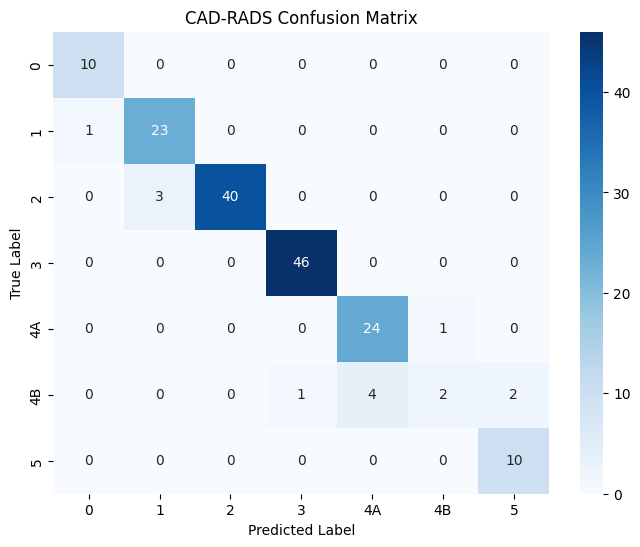

Plaque Burden Metrics:
Accuracy: 97.1%
F1 Score: 0.9707


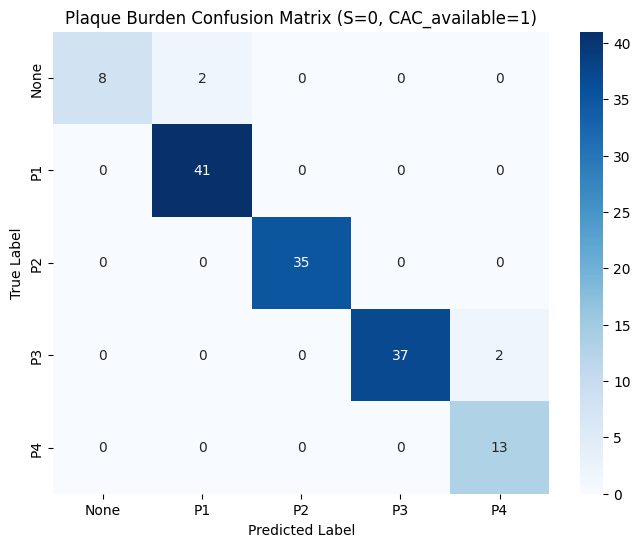

I Metrics:
Accuracy: 100.0%
F1 Score: 1.0


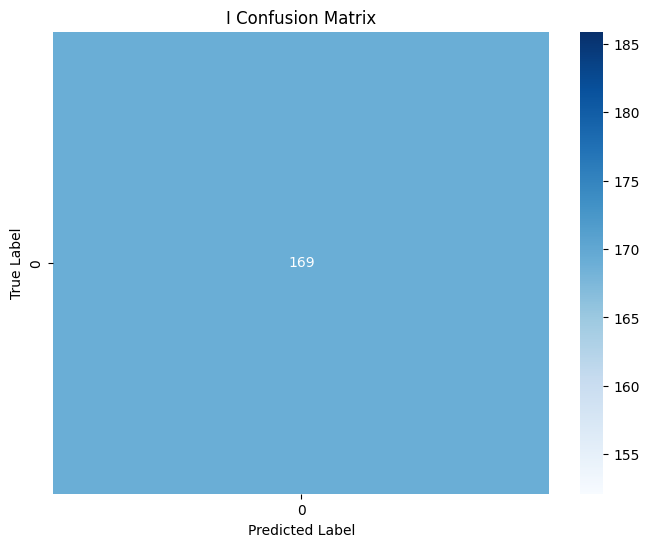

G Metrics:
Accuracy: 100.0%
F1 Score: 1.0


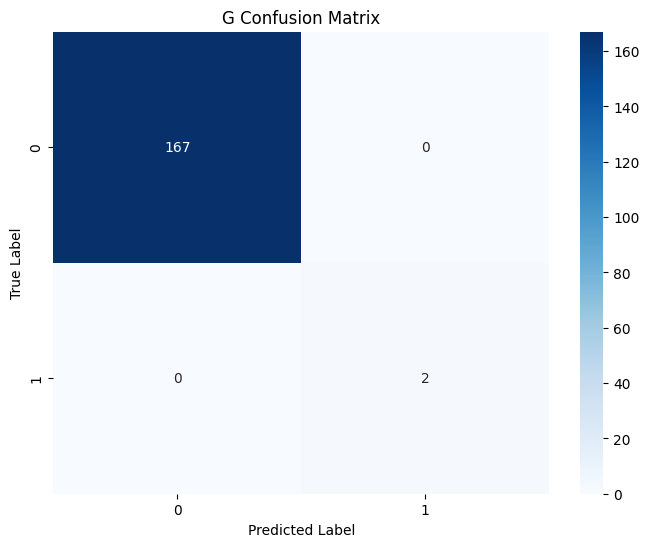

N Metrics:
Accuracy: 97.63%
F1 Score: 0.9802


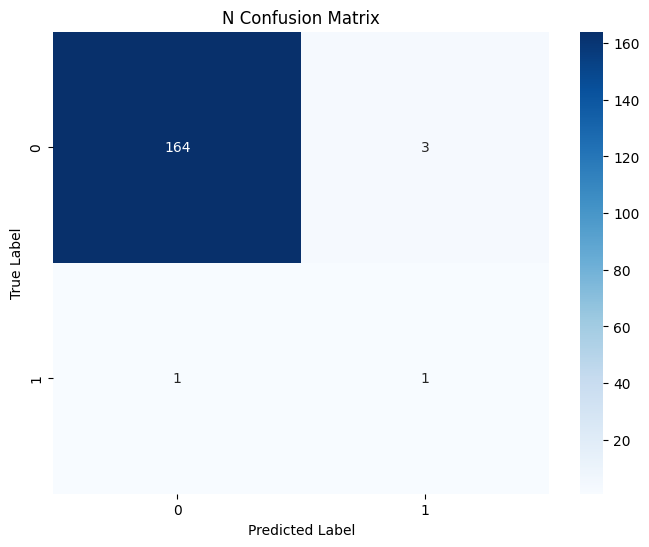

HRP Metrics:
Accuracy: 100.0%
F1 Score: 1.0


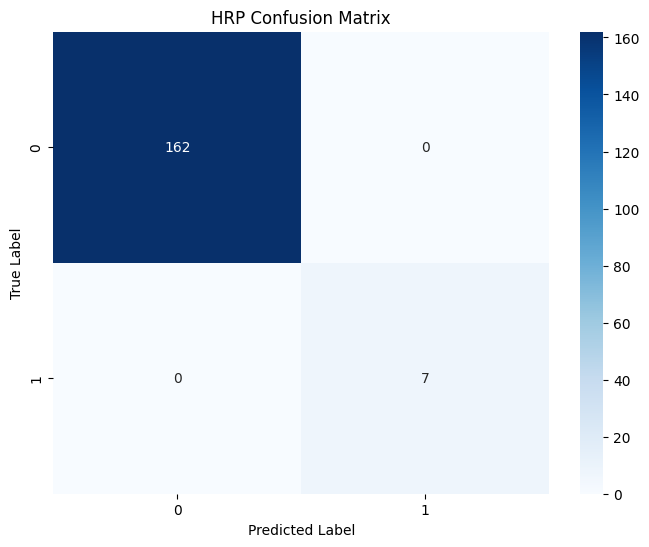

E Metrics:
Accuracy: 95.86%
F1 Score: 0.9678


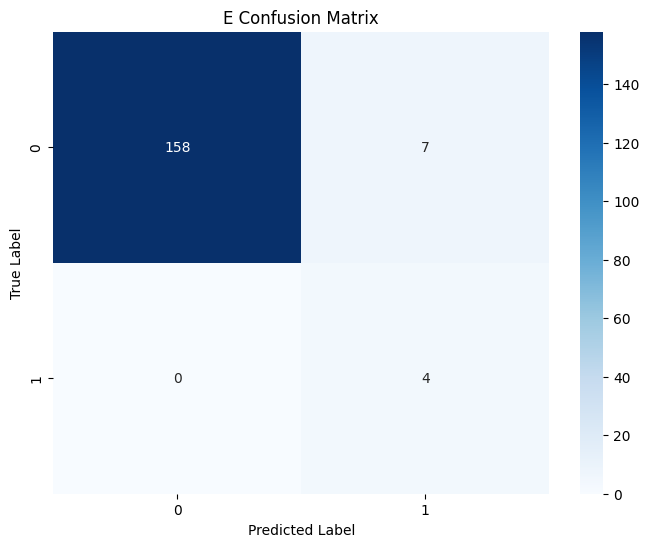

S Metrics:
Accuracy: 100.0%
F1 Score: 1.0


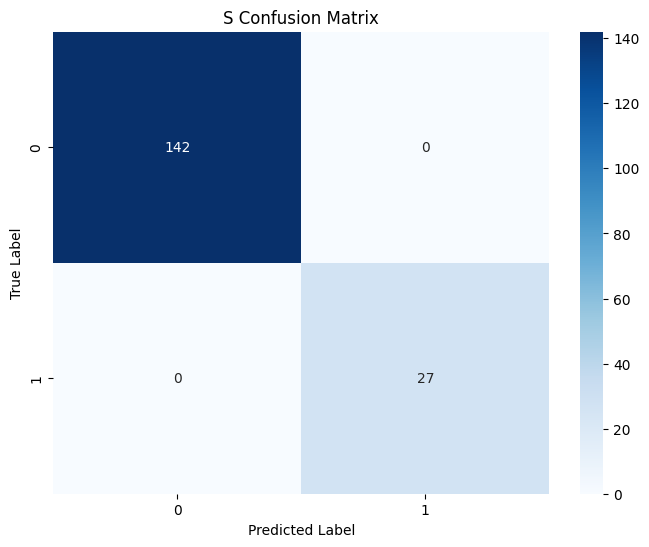

In [18]:
# 성능 평가 및 플롯 실행
performance_metrics = evaluate_performance(labels, pred)
for key, value in performance_metrics.items():
    print(f"{key} Metrics:")
    print(f"Accuracy: {round(value['Accuracy']*100,2)}%")
    print(f"F1 Score: {round(value['F1 Score'], 4)}")
    # print(f"Confusion Matrix:\n{value['Confusion Matrix']}\n")
    # 혼동 행렬 플롯
    if key in ['CAD-RADS', 'HRP', 'E', 'G', 'N', 'I', 'S']:
        class_labels = np.unique(np.concatenate((pred[key].dropna(), labels[key].dropna())))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix')
    elif key == 'Plaque Burden':
        # S가 0이고 CAC_available이 1인 경우만 선택
        mask = (labels['S'] == 0) & (labels['CAC_available'] == 1)
        plaque_data = pred[key][mask].dropna()
        plaque_labels = labels[key][mask].dropna()
        class_labels = np.unique(np.concatenate((plaque_data, plaque_labels)))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix (S=0, CAC_available=1)')

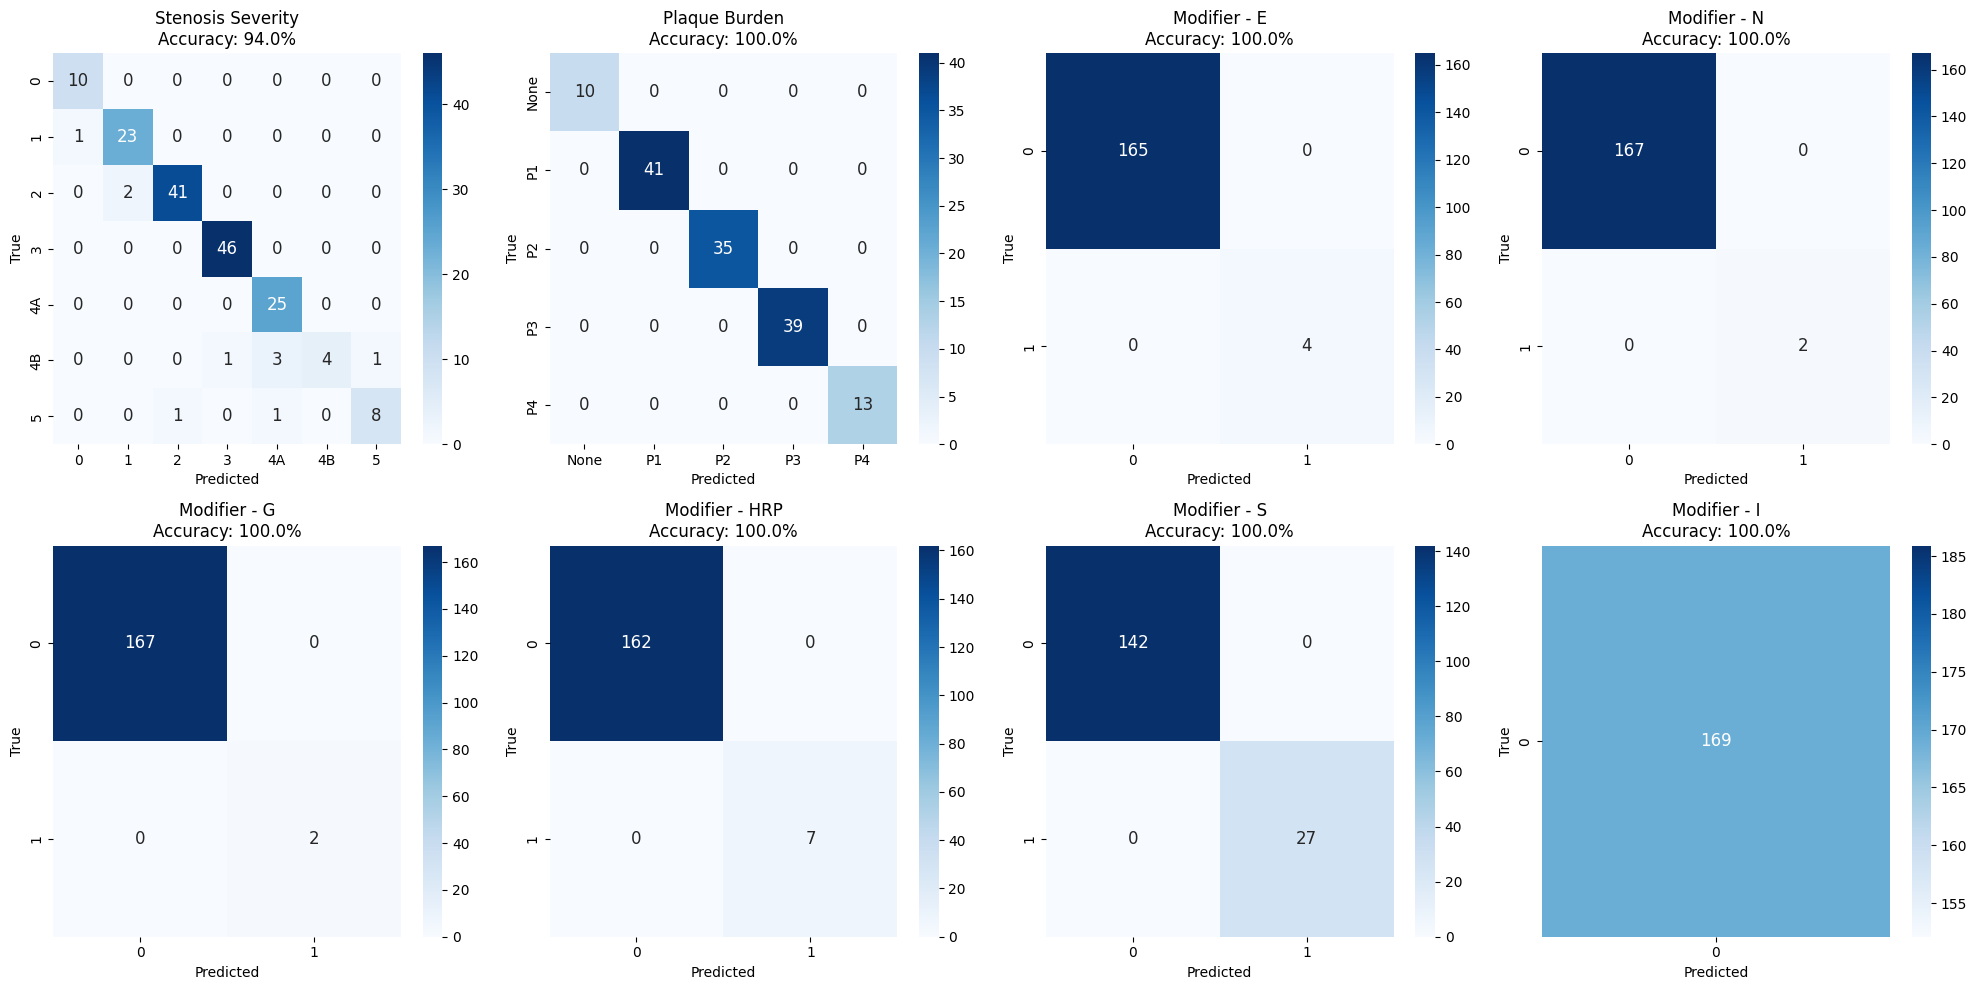

In [16]:
import seaborn as sns
def plot_combined_confusion_matrices(performance_metrics, labels, pred):
    # 그래프 크기와 subplot 구성 설정
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    # fig.suptitle('Confusion Matrices for All Components', fontsize=16)
    
    # axes를 1차원 배열로 변환하여 순차적으로 접근
    axes = axes.ravel()
    
    # 타이틀 매핑 딕셔너리 생성
    title_mapping = {
        'CAD-RADS': 'Stenosis Severity',
        'Plaque Burden': 'Plaque Burden',
        'E': 'Modifier - E',
        'N': 'Modifier - N',
        'G': 'Modifier - G',
        'HRP': 'Modifier - HRP',
        'S': 'Modifier - S',
        'I': 'Modifier - I'
    }
    
    # 원하는 순서대로 키 리스트 생성
    ordered_keys = ['CAD-RADS', 'Plaque Burden', 'E', 'N', 'G', 'HRP', 'S', 'I']
    
    # 폰트 크기 설정
    ANNOT_FONTSIZE = 12  # 숫자 크기
    LABEL_FONTSIZE = 10  # 축 라벨 크기
    TITLE_FONTSIZE = 12  # 서브플롯 제목 크기
    
    # 각 메트릭에 대해 순차적으로 plot
    for idx, key in enumerate(ordered_keys):
        value = performance_metrics[key]
        if key in ['CAD-RADS', 'E', 'N', 'G', 'HRP', 'S', 'I']:
            class_labels = np.unique(np.concatenate((pred[key].dropna(), labels[key].dropna())))
            cm = value['Confusion Matrix']
            
            # 혼동 행렬 시각화
            sns.heatmap(cm, 
                       annot=True, 
                       fmt='d', 
                       cmap='Blues',
                       xticklabels=class_labels,
                       yticklabels=class_labels,
                       ax=axes[idx],
                       annot_kws={'size': ANNOT_FONTSIZE})  # 숫자 크기 설정
            
            axes[idx].set_title(f'{title_mapping[key]}\nAccuracy: {round(value["Accuracy"]*100,1)}%', 
                              fontsize=TITLE_FONTSIZE)
            axes[idx].set_xlabel('Predicted', fontsize=LABEL_FONTSIZE)
            axes[idx].set_ylabel('True', fontsize=LABEL_FONTSIZE)
            
            # x축과 y축의 라벨 크기 설정
            axes[idx].tick_params(axis='both', labelsize=LABEL_FONTSIZE)
            
        elif key == 'Plaque Burden':
            # S가 0이고 CAC_available이 1인 경우만 선택
            mask = (labels['S'] == 0) & (labels['CAC_available'] == 1)
            plaque_data = pred[key][mask].dropna()
            plaque_labels = labels[key][mask].dropna()
            class_labels = np.unique(np.concatenate((plaque_data, plaque_labels)))
            
            cm = value['Confusion Matrix']
            sns.heatmap(cm, 
                       annot=True, 
                       fmt='d', 
                       cmap='Blues',
                       xticklabels=class_labels,
                       yticklabels=class_labels,
                       ax=axes[idx],
                       annot_kws={'size': ANNOT_FONTSIZE})  # 숫자 크기 설정
            
            axes[idx].set_title(f'{title_mapping[key]}\nAccuracy: {round(value["Accuracy"]*100,1)}%', 
                              fontsize=TITLE_FONTSIZE)
            axes[idx].set_xlabel('Predicted', fontsize=LABEL_FONTSIZE)
            axes[idx].set_ylabel('True', fontsize=LABEL_FONTSIZE)
            
            # x축과 y축의 라벨 크기 설정
            axes[idx].tick_params(axis='both', labelsize=LABEL_FONTSIZE)
    
    # 전체 레이아웃 조정
    plt.tight_layout()
    return fig

# 함수 실행
fig = plot_combined_confusion_matrices(performance_metrics, labels, pred)

# 필요한 경우 저장
plt.savefig('combined_confusion_matrices_GPT4o_external.png', dpi=300, bbox_inches='tight')
plt.show()

In [59]:
certainty_comparison = compare_certainty(labels, pred, certainty)

In [60]:
# 결과 출력
for category, values in certainty_comparison.items():
    print(f"\n{category}:")
    print(f"  Correct predictions:")
    print(f"    Average: {values['Avg Certainty (Correct)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Correct)']:.4f}")
    print(f"  Incorrect predictions:")
    print(f"    Average: {values['Avg Certainty (Incorrect)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Incorrect)']:.4f}")
    print(f"  Difference in averages: {values['Difference']:.4f}")
    print(f"  T-statistic: {values['t-statistic']:.4f}")
    print(f"  P-value: {values['p-value']:.4f}")
    print(f"  Statistical Significance: {'Significant' if values['p-value'] < 0.05 else 'Not Significant'}")


CAD-RADS:
  Correct predictions:
    Average: 9.8734
    Std Dev: 0.4183
  Incorrect predictions:
    Average: 9.4000
    Std Dev: 0.8433
  Difference in averages: 0.4734
  T-statistic: 3.2142
  P-value: 0.0016
  Statistical Significance: Significant

Plaque Burden:
  Correct predictions:
    Average: 9.9489
    Std Dev: 0.2210
  Incorrect predictions:
    Average: 10.0000
    Std Dev: nan
  Difference in averages: -0.0511
  T-statistic: -0.2304
  P-value: 0.8182
  Statistical Significance: Not Significant


# Claude3.5 sonnet

In [18]:
labels = data.iloc[:,4:]

# pred = pd.read_excel('result_0827_external_claude_v5.0.xlsx')
# pred = pred.iloc[:,-8:]

# pred = pd.read_excel('result_0829_external_claude_v5.1_CoT_x_after_answer_x_none.xlsx')
pred = pd.read_excel('result_0930_external_claude_v6.0_CoT_edit.xlsx')
pred = pred.iloc[:,-9:-1]

# 모든 컬럼 이름에서 '.1' 제거
pred.columns = pred.columns.str.replace('.1', '')
pred = pred[labels.iloc[:,:-1].columns]

C:\Users\User\AppData\Local\Temp\ipykernel_35548\3244121596.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


CAD-RADS Metrics:
Accuracy: 88.55%
F1 Score: 0.7369


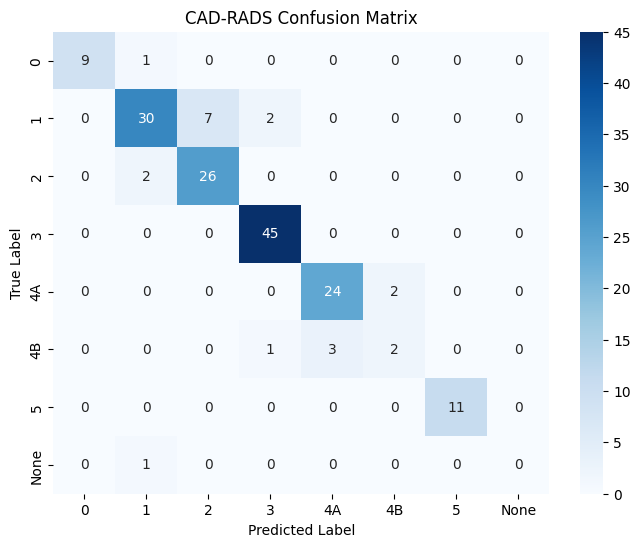

Plaque Burden Metrics:
Accuracy: 92.91%
F1 Score: 0.9085


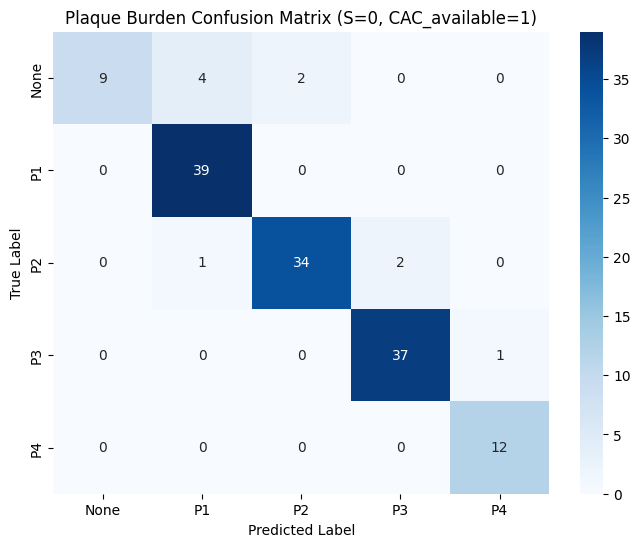

I Metrics:
Accuracy: 100.0%
F1 Score: 1.0


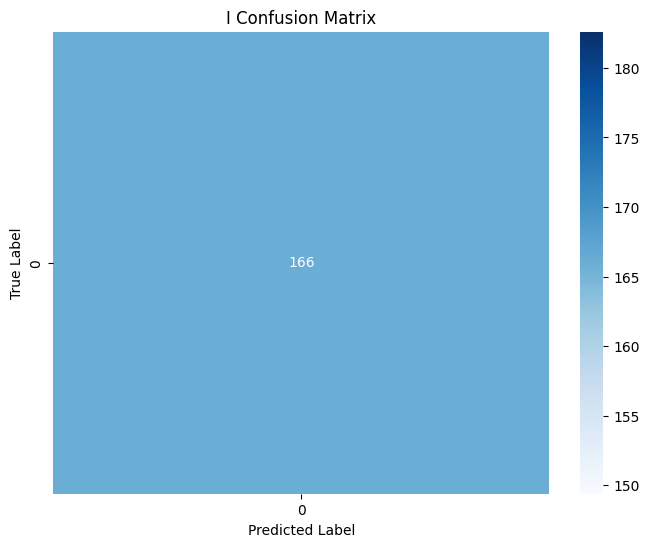

G Metrics:
Accuracy: 99.4%
F1 Score: 0.8318


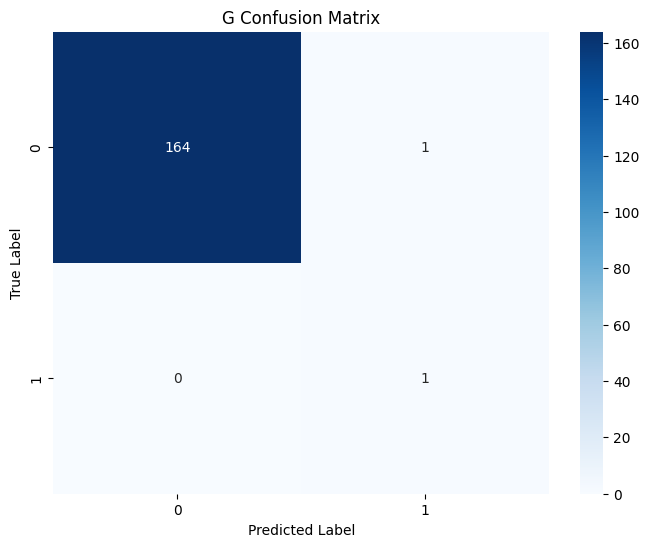

N Metrics:
Accuracy: 96.39%
F1 Score: 0.6907


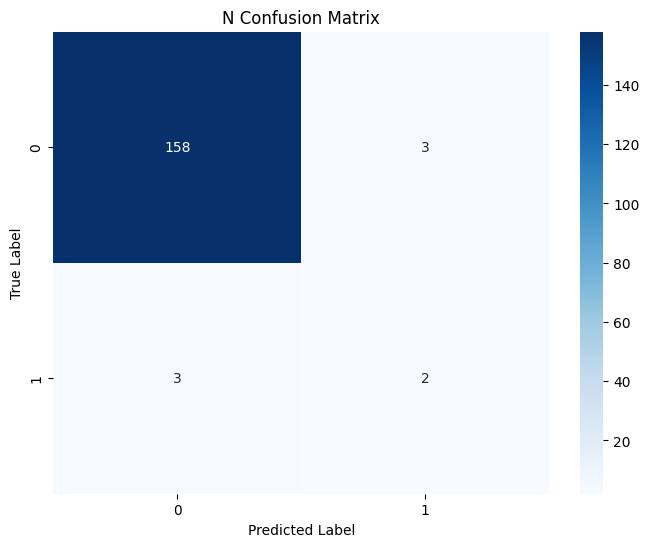

HRP Metrics:
Accuracy: 97.59%
F1 Score: 0.8509


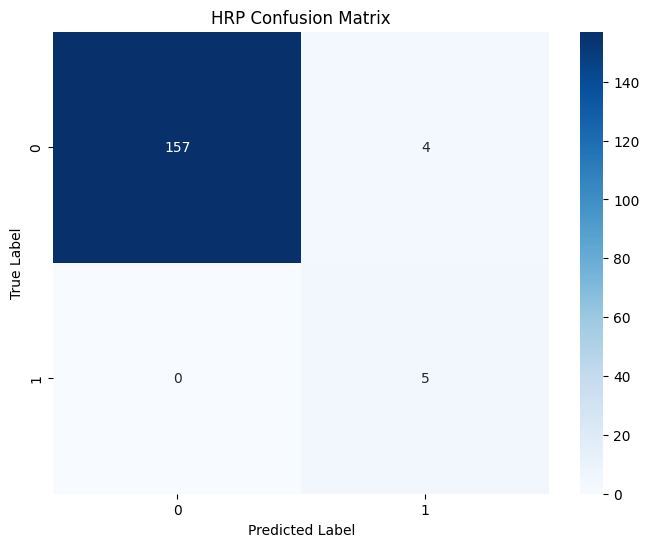

E Metrics:
Accuracy: 99.4%
F1 Score: 0.9429


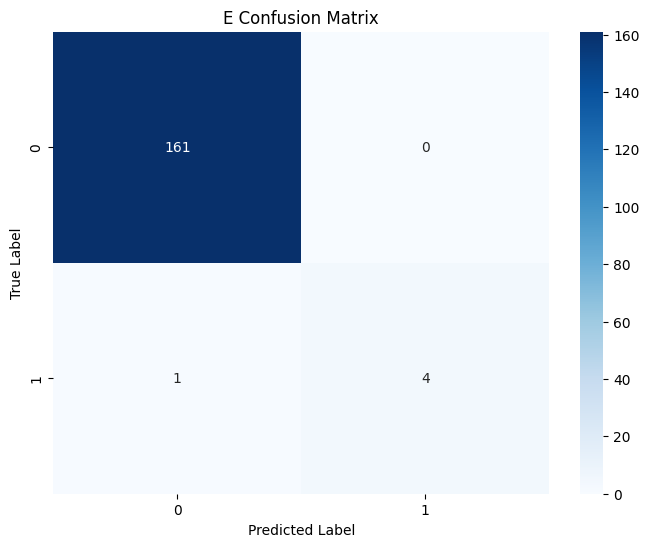

S Metrics:
Accuracy: 100.0%
F1 Score: 1.0


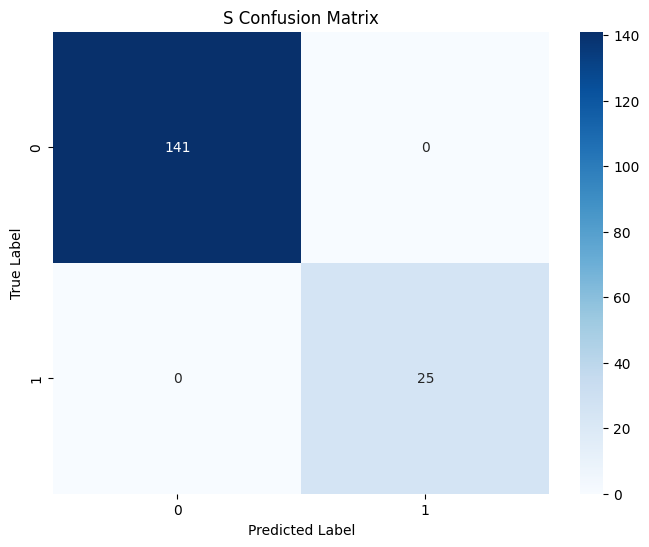

In [19]:
# 성능 평가 및 플롯 실행
performance_metrics = evaluate_performance(labels, pred)
for key, value in performance_metrics.items():
    print(f"{key} Metrics:")
    print(f"Accuracy: {round(value['Accuracy']*100,2)}%")
    print(f"F1 Score: {round(value['F1 Score'], 4)}")
    # print(f"Confusion Matrix:\n{value['Confusion Matrix']}\n")
    # 혼동 행렬 플롯
    if key in ['CAD-RADS', 'HRP', 'E', 'G', 'N', 'I', 'S']:
        class_labels = np.unique(np.concatenate((pred[key].dropna(), labels[key].dropna())))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix')
    elif key == 'Plaque Burden':
        # S가 0이고 CAC_available이 1인 경우만 선택
        mask = (labels['S'].iloc[3:] == 0) & (labels['CAC_available'].iloc[3:] == 1)
        plaque_data = pred[key].iloc[3:][mask].dropna()
        plaque_labels = labels[key].iloc[3:][mask].dropna()
        class_labels = np.unique(np.concatenate((plaque_data, plaque_labels)))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix (S=0, CAC_available=1)')

# Gemini

In [18]:
labels = data.iloc[:,4:]

# pred = pd.read_excel('result_0828_external_gemini_v5.1.xlsx')
# pred = pred.iloc[:,-8:]

# pred = pd.read_excel('result_0829_external_gemini_v5.1_CoT_x_after_answer_x_none.xlsx')
pred = pd.read_excel('result_0930_external_gemini_v6.0_CoT_edit.xlsx')
pred = pred.iloc[:,-9:-1]

# 모든 컬럼 이름에서 '.1' 제거
pred.columns = pred.columns.str.replace('.1', '')
pred = pred[labels.iloc[:,:-1].columns]

C:\Users\User\AppData\Local\Temp\ipykernel_129860\260083911.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


CAD-RADS Metrics:
Accuracy: 82.53%
F1 Score: 0.7061


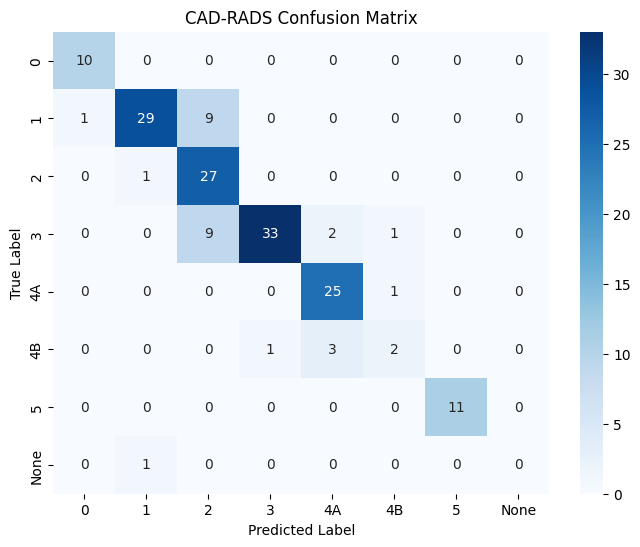

Plaque Burden Metrics:
Accuracy: 93.62%
F1 Score: 0.9222


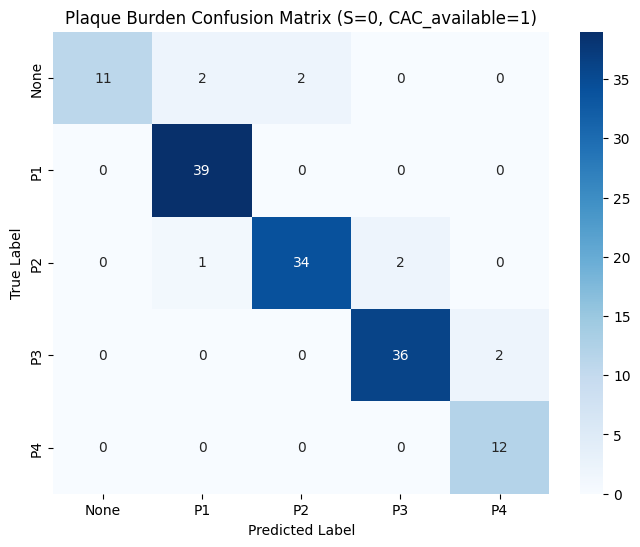

I Metrics:
Accuracy: 100.0%
F1 Score: 1.0


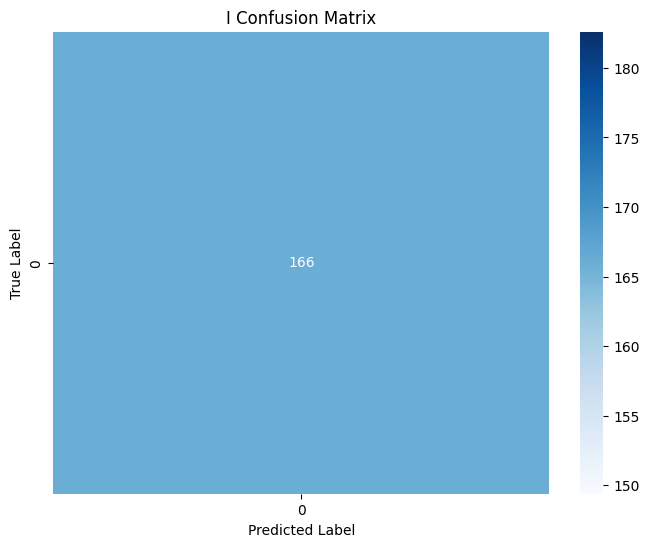

G Metrics:
Accuracy: 99.4%
F1 Score: 0.8318


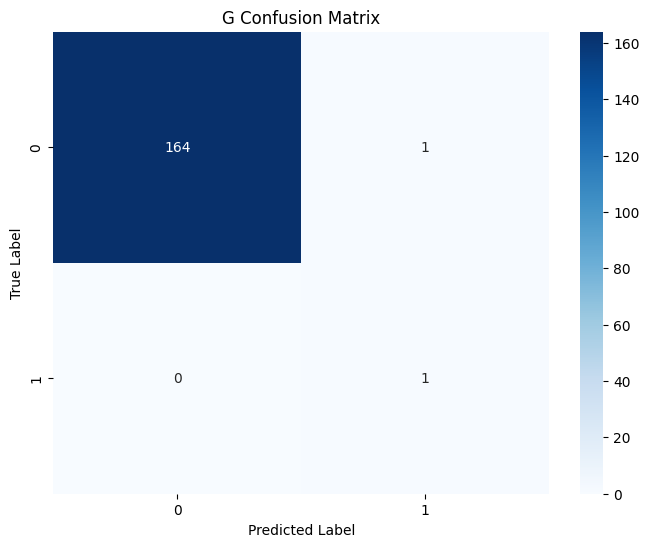

N Metrics:
Accuracy: 95.18%
F1 Score: 0.5876


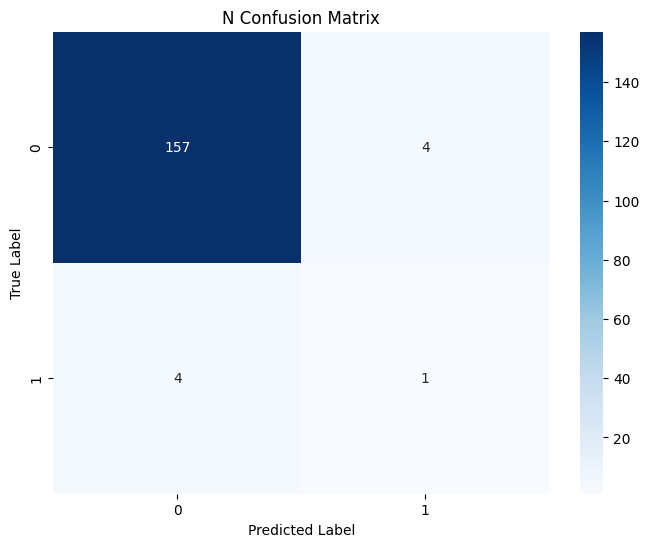

HRP Metrics:
Accuracy: 92.77%
F1 Score: 0.7079


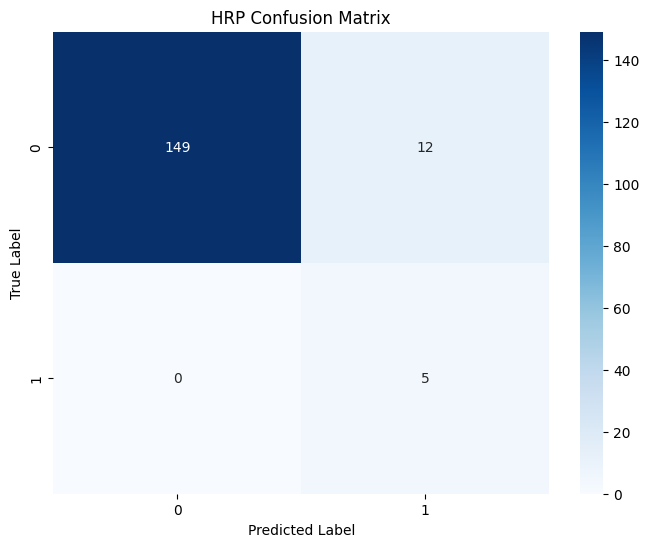

E Metrics:
Accuracy: 98.8%
F1 Score: 0.8969


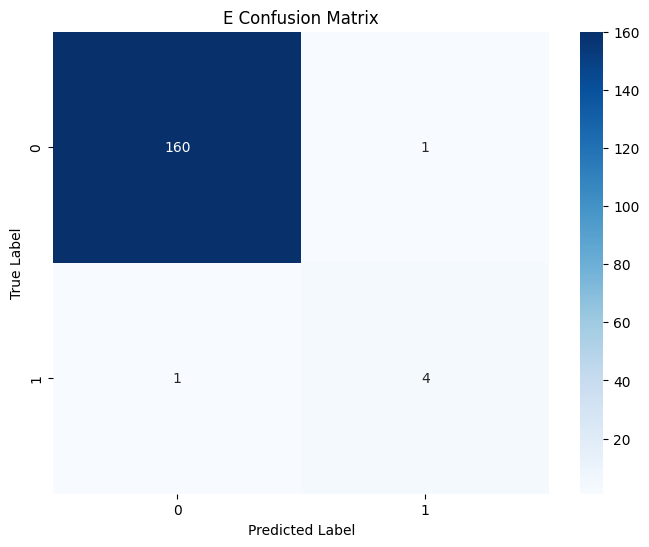

S Metrics:
Accuracy: 99.4%
F1 Score: 0.988


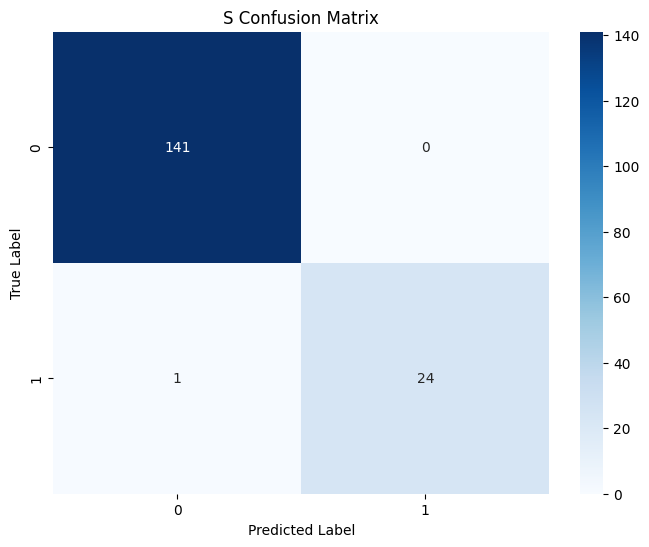

In [19]:
# 성능 평가 및 플롯 실행
performance_metrics = evaluate_performance(labels, pred)
for key, value in performance_metrics.items():
    print(f"{key} Metrics:")
    print(f"Accuracy: {round(value['Accuracy']*100,2)}%")
    print(f"F1 Score: {round(value['F1 Score'], 4)}")
    # print(f"Confusion Matrix:\n{value['Confusion Matrix']}\n")
    # 혼동 행렬 플롯
    if key in ['CAD-RADS', 'HRP', 'E', 'G', 'N', 'I', 'S']:
        class_labels = np.unique(np.concatenate((pred[key].dropna(), labels[key].dropna())))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix')
    elif key == 'Plaque Burden':
        # S가 0이고 CAC_available이 1인 경우만 선택
        mask = (labels['S'].iloc[3:] == 0) & (labels['CAC_available'].iloc[3:] == 1)
        plaque_data = pred[key].iloc[3:][mask].dropna()
        plaque_labels = labels[key].iloc[3:][mask].dropna()
        class_labels = np.unique(np.concatenate((plaque_data, plaque_labels)))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix (S=0, CAC_available=1)')